# Modelling of a Geared DC Motor

**Balck-box modelling of a DC Motor using FNN, CNN and LSTM**

- Input: PWM signal
- Output : Angular speed

<h5> DC Motor specification </h5>

-   12 DVC
-   Gear ration 10:1


<h4> Experimental Settings  </h4>

-   Sampling time- 0.002s
-   Duration- 500s

In [23]:
#  Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow
tensorflow.random.set_seed(1000)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Flatten, Dropout,InputLayer

from tensorflow.keras.layers import RNN, Layer,LSTM, SimpleRNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow import float32, concat, convert_to_tensor, linalg



In [24]:
# data
exp_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_training.csv')
exp_data

,0,40.5,0.1
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


In [25]:
exp_data.columns = ['time', 'voltage', 'speed']
exp_data

,time,voltage,speed
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Samual\Anaconda3\envs\deep_env2\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


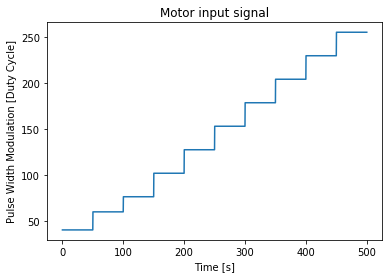

In [26]:
# Motor Input Signal
plt.plot(exp_data['time'][:-1],exp_data['voltage'][:-1])
plt.ylabel('Pulse Width Modulation [Duty Cycle]')
plt.xlabel('Time [s]')
plt.title('Motor input signal')
plt.show()
print('\n')

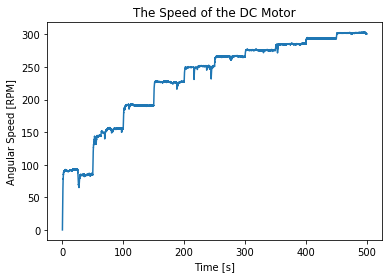

In [27]:
# Motor Output Plot
plt.plot(exp_data['time'][:-1],exp_data['speed'][:-1])
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

In [28]:
# Data for training
exp_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_training.csv')
exp_data.columns = ['time', 'voltage', 'speed']
# range
l=25000
exp_data_tr=exp_data.iloc[0:l,:]

time=exp_data_tr['time']
t=np.array(time)

input_1=exp_data_tr['voltage']
xtr=np.array(input_1)
X_train=xtr.reshape(l,1)

output_1=exp_data_tr['speed']
ytr=np.array(output_1)
Y_train=ytr.reshape(l,1)

#Data for testing
new_data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Neural Networks and ML- Geared DC Motor Case Study/DC_Motor_experimental_data_testing.csv')
new_data.columns = ['time', 'voltage', 'speed']

time_test=new_data['time']
t_test=np.array(time_test)

input_2=new_data['voltage']
xts=np.array(input_2)
X_test=xts.reshape(l,1)

output_2=new_data['speed']
yts=np.array(output_2)
Y_test=yts.reshape(l,1)

<h2> Data Transformation<h2>

In [29]:

def data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for CNN and LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, Y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x data
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y data
        seq_Y = y_data[end_ix]
        # Append the list with the sequence
        X.append(seq_X)
        Y.append(seq_Y)
    # Make final arrays
    x_trans_array = np.array(X)
    y_trans_array = np.array(Y)
    return x_trans_array, y_trans_array

In [30]:
# Training Data
num_steps = 1
x_new, y_new = data_transform(X_train, Y_train, num_steps=num_steps)
#print(x_new)
print ("The transformed shape of x and y are:", x_new.shape,"and", y_new.shape)

The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


In [31]:
# Test data
num_steps = 1
x_nnew, y_nnew = data_transform(X_test, Y_test, num_steps=num_steps)
print ("The transformed shape of x and y are:", x_nnew.shape,"and",y_nnew.shape)

The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


<h2>Feedforward Neural Network (FNN) Model<h2>

In [32]:
model0=Sequential()
model0.add(Dense(100, input_dim=1,activation='tanh'))
model0.add(Dense(50, input_dim=1,activation='tanh'))
model0.add(Dense(10, activation='relu'))
model0.add(Dense(1,activation="linear"))
model0.summary()

#compile model
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model0.compile(optimizer=opt, loss='mse')

from time import time
# Start timer
t0 = time()
#hist0=model0.fit(X_train,Y_train,epochs=10,validation_data = (X_test, Y_test),verbose=2)
hist0=model0.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 5,771
Trainable params: 5,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 - 9s - loss: 54626.5117 - val_loss: 51990.1758
Epoch 2/20
782/782 - 7s - loss: 49628.3164 - val_loss: 46598.4297
Epoch 3/20
782/782 - 7s - loss: 43692.9453 - val_loss: 40272.1016
Epoch 4/20
782/782 - 7s - loss: 37093.2773 - val_los

dict_keys(['loss', 'val_loss'])


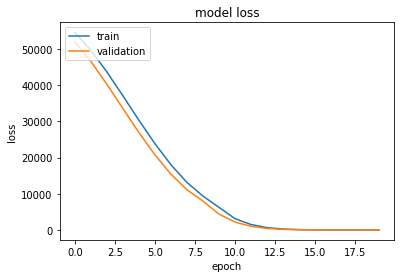

In [33]:
#Plotting of Loss
print(hist0.history.keys())
plt.plot(hist0.history['loss'])
plt.plot(hist0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
# Prediiction with test data
prediction0=model0.predict(x_nnew) ######### prediction with test data
print(prediction0.shape)
prediction0

(24999, 1)


array([[ 85.95833],
       [ 85.95833],
       [ 85.95833],
       ...,
       [300.0252 ],
       [300.0252 ],
       [300.0252 ]], dtype=float32)

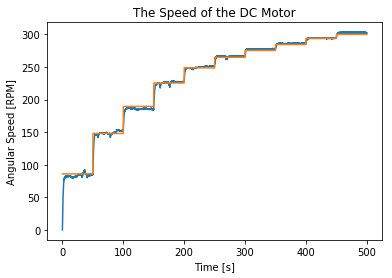

In [35]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction0)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save FNN Model<h5>

In [36]:
# save model and architecture to single file
model0.save("DC_motor_model_FNN.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_FNN = load_model('DC_motor_model_FNN.h5')

Model has been saved to disk


<h2>Convolutional Neural Network (CNN) Model<h2>

In [39]:
model1=Sequential()
model1.add(Conv1D(filters=128,kernel_size=1, activation='tanh', input_shape=(num_steps,1)))
model1.add(Conv1D(filters=64,kernel_size=1, activation='tanh'))
model1.add(Flatten())
model1.add(Dense(5, activation='relu'))
model1.add(Dense(1, activation='linear'))

# Model Compile and Fit
opt = tensorflow.keras.optimizers.Adam(lr=0.0001)
model1.compile(optimizer=opt, loss='mse')
model1.summary()

from time import time
# Start timer
t0 = time()
hist1=model1.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 128)            256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             8256      
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 325       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 8,843
Trainable params: 8,843
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 - 10s - loss: 54629.4141 - val_loss: 52444.9219
Epoch 2/20
782/782 - 10s - loss: 50771.9141 - val_l

dict_keys(['loss', 'val_loss'])


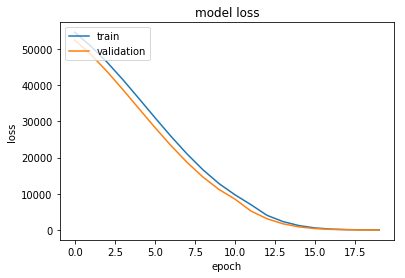

In [40]:
#Plotting of Loss
print(hist1.history.keys())
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# Prediiction with test data
prediction1=model1.predict(x_nnew) ######### prediction with test data
print(prediction1.shape)
prediction1

(24999, 1)


array([[ 85.954216],
       [ 85.954216],
       [ 85.954216],
       ...,
       [293.89294 ],
       [293.89294 ],
       [293.89294 ]], dtype=float32)

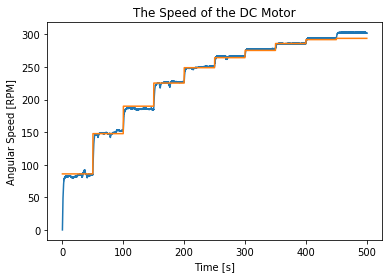

In [42]:
# Plottinf the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction1)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save CNN Model<h5>

In [43]:
# save model and architecture to single file
model1.save("DC_motor_model_CNN.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_CNN = load_model('DC_motor_model_CNN.h5')

Model has been saved to disk


<h2>Long Short Term Memory (LSTM) Model<h2>

In [46]:
model2 = Sequential()
model2.add(LSTM(100, activation='tanh', input_shape=(num_steps, 1),return_sequences=False))
model2.add(Dense(units=50, activation='relu'))
model2.add(Dense(units=1, activation='linear'))
adam = tensorflow.keras.optimizers.Adam(lr=0.0001)
model2.compile(optimizer=adam, loss='mse')
from time import time
# Start timer
t0 = time()
hist2=model2.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


Epoch 1/20
782/782 - 18s - loss: 53845.8008 - val_loss: 42394.6641
Epoch 2/20
782/782 - 10s - loss: 30178.4902 - val_loss: 19926.4336
Epoch 3/20
782/782 - 10s - loss: 13058.8613 - val_loss: 7482.3369
Epoch 4/20
782/782 - 10s - loss: 4210.4932 - val_loss: 1954.6852
Epoch 5/20
782/782 - 10s - loss: 937.0470 - val_loss: 382.2837
Epoch 6/20
782/782 - 10s - loss: 196.7442 - val_loss: 108.6344
Epoch 7/20
782/782 - 10s - loss: 67.5913 - val_loss: 52.2988
Epoch 8/20
782/782 - 10s - loss: 39.7182 - val_loss: 35.4640
Epoch 9/20
782/782 - 10s - loss: 29.8645 - val_loss: 32.5146
Epoch 10/20
782/782 - 10s - loss: 25.2412 - val_loss: 25.3041
Epoch 11/20
782/782 - 10s - loss: 22.9669 - val_loss: 27.3821
Epoch 12/20
782/782 - 9s - loss: 21.7613 - val_loss: 25.8410
Epoch 13/20
782/782 - 9s - loss: 21.2919 - val_loss: 27.1378
Epoch 14/20
782/782 - 10s - loss: 20.7978 - val_loss: 23.9803
Epoch 15/20
782/782 - 10s - loss: 20.6214 - val_loss: 26.9662
Epoch 16/20
782/782 - 10s - loss: 20.4663 - val_loss: 24

dict_keys(['loss', 'val_loss'])


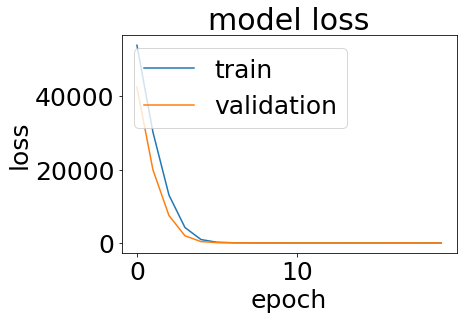

In [47]:
#Plotting of Loss
print(hist2.history.keys())
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [48]:
# Prediiction with test data
prediction2=model2.predict(x_nnew) ######### prediction with test data
print(prediction2.shape)
prediction2

(24999, 1)


array([[ 85.246666],
       [ 85.246666],
       [ 85.246666],
       ...,
       [300.62396 ],
       [300.62396 ],
       [300.62396 ]], dtype=float32)

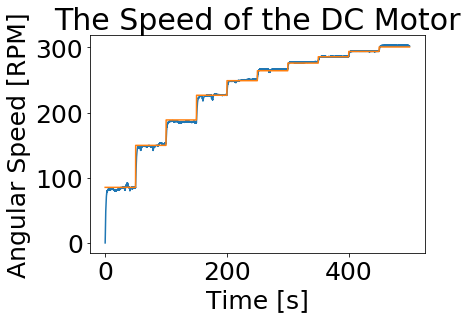

In [49]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction2)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h5>Save LSTM Model<h5>

In [50]:
# save model and architecture to single file
model2.save("DC_motor_model_LSTM.h5")
print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model_LSTM = load_model('DC_motor_model_LSTM.h5')

Model has been saved to disk


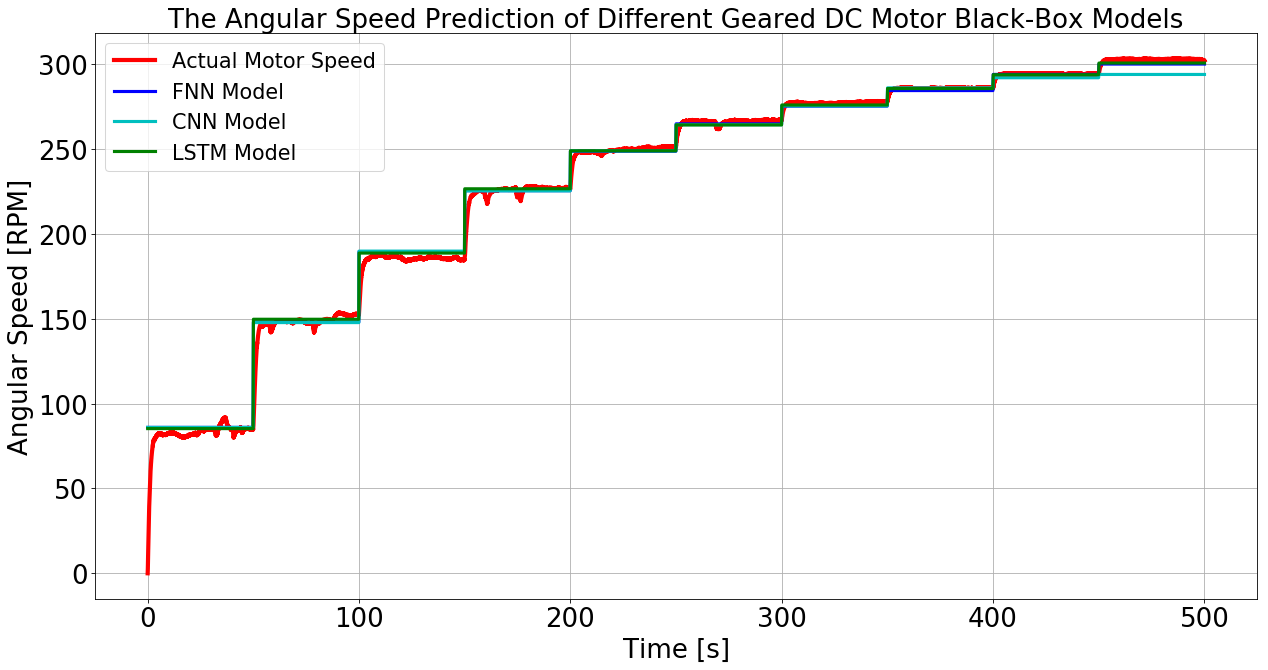

In [52]:
# Plotting the Models
from matplotlib.pyplot import figure
fig=plt.figure(figsize=(20,10),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_test[num_steps:],y_nnew, color='r',linewidth=4,label="Actual Motor Speed")
plt.plot(t_test[num_steps:],prediction0, color='b',linewidth=3,label="FNN Model")
plt.plot(t_test[num_steps:],prediction1, color='c',linewidth=3,label="CNN Model")
plt.plot(t_test[num_steps:],prediction2, color='g',linewidth=3,label="LSTM Model")
plt.ylabel('Angular Speed [RPM]',fontsize=25)
plt.xlabel('Time [s]',fontsize=25)
plt.title('The Angular Speed Prediction of Different Geared DC Motor Black-Box Models',fontsize=25)
plt.legend(loc=2, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("Black-box models.png") 
